Link to competition: https://www.kaggle.com/c/fungi-challenge-fgvc-2018/overview

# Preparations

In [1]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
from fastai.vision import * 
from fastai.metrics import top_k_accuracy
import json

In [3]:
batch_size = 64

In [4]:
np.random.seed(1991)

# Loading Data

In [5]:
data_path_str = "data"
train_path_str = "train"
test_path_str = "test"

In [6]:
doc(ImageDataBunch.from_folder)

In [9]:
data = ImageDataBunch.from_folder(
    path = data_path_str,
    train = train_path_str,
    test = test_path_str,
    size = 128,
    ds_tfms = get_transforms(),
    bs = batch_size,
    valid_pct = 0.2
).normalize(imagenet_stats)

In [67]:
data

ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
16111_Leccinum_scabrum,14062_Fomes_fomentarius,14861_Gliophorus_psittacinus,11903_Coniophora_puteana,18776_Piptoporus_betulinus
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data

# Visualize Data

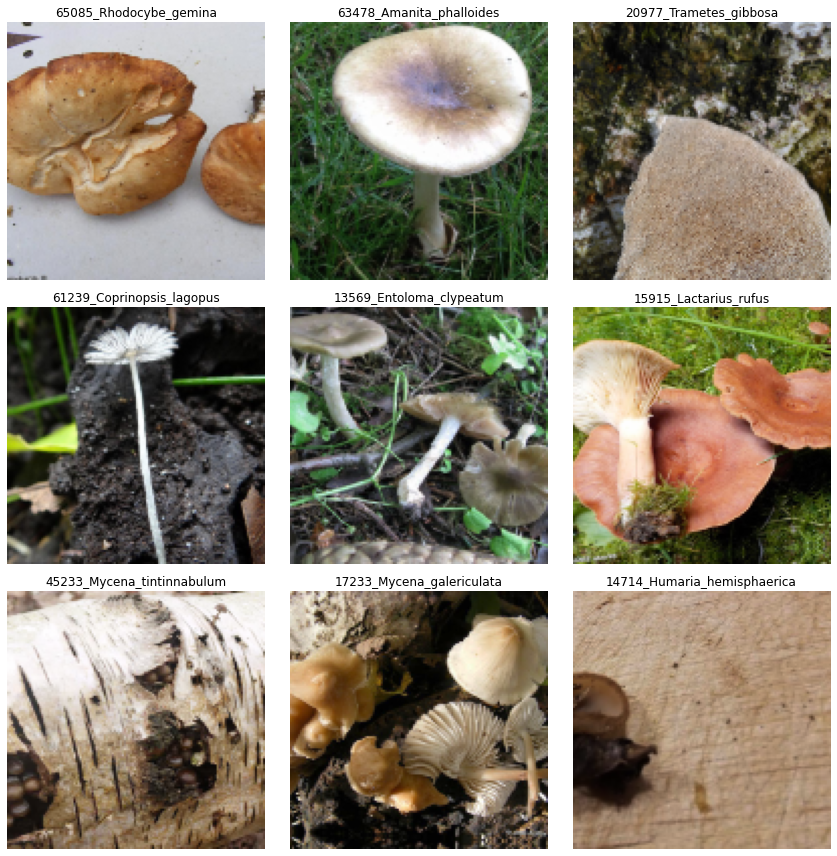

In [68]:
data.show_batch(3)

In [69]:
type(data)

fastai.vision.data.ImageDataBunch

In [70]:
data.c

1394

In [71]:
data.classes

['10000_Abortiporus_biennis',
 '10025_Achroomyces_disciformis',
 '10052_Agaricus_altipes',
 '10056_Agaricus_arvensis',
 '10057_Agaricus_augustus',
 '10059_Agaricus_bernardii',
 '10061_Agaricus_bisporus',
 '10062_Agaricus_bitorquis',
 '10065_Agaricus_campestris',
 '10068_Agaricus_comtulus',
 '10069_Agaricus_cupreobrunneus',
 '10079_Agaricus_impudicus',
 '10082_Agaricus_langei',
 '10083_Agaricus_lanipes',
 '10085_Agaricus_litoralis',
 '10090_Agaricus_moelleri',
 '10097_Agaricus_porphyrizon',
 '10106_Agaricus_dulcidulus',
 '10107_Agaricus_sylvaticus',
 '10108_Agaricus_sylvicola',
 '10111_Agaricus_subfloccosus',
 '10112_Agaricus_subperonatus',
 '10116_Agaricus_xanthodermus',
 '10120_Agrocybe_arvalis',
 '10123_Agrocybe_dura',
 '10127_Agrocybe_pediades',
 '10128_Agrocybe_praecox',
 '10158_Aleuria_aurantia',
 '10174_Aleurodiscus_amorphus',
 '10225_Amanita_ceciliae',
 '10227_Amanita_crocea',
 '10230_Amanita_excelsa',
 '10232_Amanita_franchetii',
 '10234_Amanita_fulva',
 '10235_Amanita_gemmata'

In [72]:
from itertools import groupby

In [73]:
data.y.items

array([1357, 1357, 1357, 1357, ...,  342,  342,  342,  342])

In [74]:
CategoryList(data.y.items, data.y.classes)

CategoryList (71808 items)
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: .

In [75]:
data.y.classes[data.y.items[0]]

'67347_Gliophorus_irrigatus'

In [76]:
labels = [data.y.classes[value] for value in data.y.items]

In [77]:
label_freq = {key: len(list(group)) for key, group in groupby(labels)}

In [78]:
min(label_freq, key=label_freq.get)

'11748_Clitocybe_alexandri'

In [79]:
max(label_freq, key=label_freq.get)

'18882_Plicatura_crispa'

In [80]:
label_freq

{'67347_Gliophorus_irrigatus': 71,
 '13598_Entoloma_exile': 27,
 '60665_Diatrype_decorticata': 31,
 '14610_Helvella_elastica': 56,
 '64651_Hymenoscyphus_fraxineus': 17,
 '18475_Phleogena_faginea': 19,
 '17963_Panellus_mitis': 54,
 '19964_Russula_emetica': 39,
 '45206_Mycena_galopus var. nigra': 29,
 '15468_Inocybe_rimosa': 102,
 '11866_Coltricia_confluens': 20,
 '18925_Pluteus_umbrosus var. umbrosus ': 44,
 '20829_Tapinella_panuoides': 59,
 '63806_Antrodiella_faginea': 5,
 '12479_Cortinarius_largus': 163,
 '12785_Crepidotus_variabilis': 82,
 '18712_Phyllotopsis_nidulans': 16,
 '14069_Fuligo_leviderma': 6,
 '11575_Chamaemyces_fracidus': 5,
 '63641_Hygrocybe_miniata': 123,
 '44721_Mycetinis_querceus': 21,
 '61211_Coprinellus_xanthothrix': 40,
 '11286_Calyptella_gibbosa': 8,
 '20225_Scleroderma_verrucosum': 82,
 '15328_Inocybe_bongardii': 14,
 '18329_Phaeolus_schweinitzii': 138,
 '60939_Sarcomyxa_serotina': 59,
 '17150_Morchella_conica': 12,
 '61650_Tricholoma_frondosae': 21,
 '19919_Russ

<BarContainer object of 1394 artists>

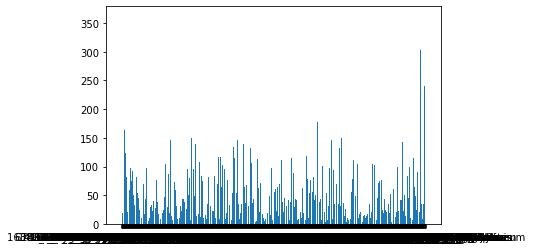

In [81]:
plt.bar(label_freq.keys(), label_freq.values())

# Training the model

In [7]:
top_k_accuracy_3 = partial(top_k_accuracy, k=3)

In [10]:
learner = cnn_learner(data, models.resnet34, metrics=top_k_accuracy_3)

In [84]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


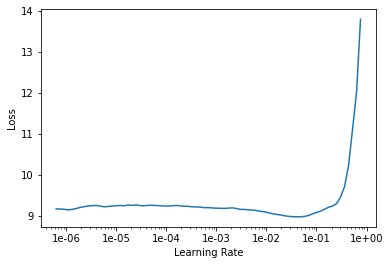

In [85]:
learner.recorder.plot()

In [86]:
lr = 1e-02

In [87]:
fit_one_cycle(learner, 3, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,5.308396,5.010071,0.200089,06:40
1,4.583510,4.138457,0.347872,06:39
2,4.110500,3.720205,0.427195,06:40


In [88]:
learner.save("fungi_resnet34_128_stage1")

## Fine Tuning

In [92]:
learner.load("fungi_resnet34_128_stage1")

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
16111_Leccinum_scabrum,14062_Fomes_fomentarius,14861_Gliophorus_psittacinus,11903_Coniophora_puteana,18776_Piptoporus_betulinus
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [93]:
learner.unfreeze()

In [94]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


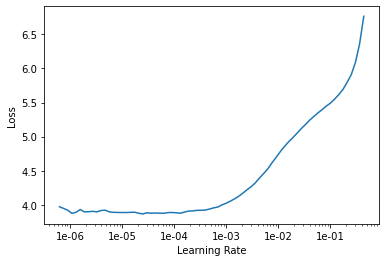

In [95]:
learner.recorder.plot()

In [99]:
lr = slice(1e-6,1e-04)

In [100]:
learner.fit_one_cycle(3, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,3.916291,3.649960,0.439672,06:40
1,3.799667,3.568113,0.450758,06:41
2,3.746780,3.545931,0.454824,06:41


In [101]:
learner.save("fungi_resnet34_128_stage2")

In [104]:
learner.fit_one_cycle(2, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,3.706605,3.507722,0.461063,06:39
1,3.664130,3.476113,0.465909,06:41


In [105]:
learner.save("fungi_resnet34_128_stage3")

## Training With Bigger Images

In [11]:
learner.load("fungi_resnet34_128_stage3")

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
16111_Leccinum_scabrum,14062_Fomes_fomentarius,14861_Gliophorus_psittacinus,11903_Coniophora_puteana,18776_Piptoporus_betulinus
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [12]:
data = ImageDataBunch.from_folder(
    path = data_path_str,
    train = train_path_str,
    test = test_path_str,
    size = 256,
    ds_tfms = get_transforms(),
    bs = batch_size,
    valid_pct = 0.2
).normalize(imagenet_stats)

In [13]:
learner.data = data

In [17]:
learner.freeze()

In [14]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


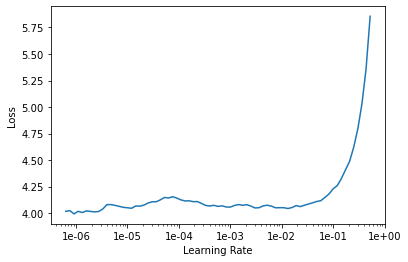

In [15]:
learner.recorder.plot()

In [16]:
lr = 1e-02

In [18]:
fit_one_cycle(learner, 3, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,4.227657,3.801559,0.404969,16:07
1,3.744261,3.150674,0.523284,11:11
2,3.147688,2.765649,0.592190,11:09


In [19]:
learner.save("fungi_resnet34_256_stage1")

### Fine Tuning

In [20]:
learner.load("fungi_resnet34_256_stage1")

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
61255_Coprinopsis_stercorea,10235_Amanita_gemmata,19336_Deconica_montana,10266_Amanita_strobiliformis,21143_Tricholoma_scalpturatum
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [21]:
learner.unfreeze()

In [22]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


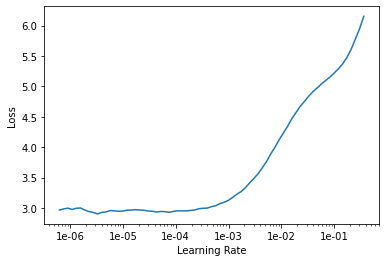

In [23]:
learner.recorder.plot()

In [24]:
lr = slice(1e-6,1e-04)

In [25]:
learner.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,2.966246,2.731215,0.598095,11:26
1,2.915502,2.656915,0.611798,11:23
2,2.857046,2.599371,0.620488,11:14
3,2.825556,2.571108,0.623552,11:34
4,2.776285,2.568284,0.624721,11:26


In [101]:
learner.save("fungi_resnet34_256_stage2")

# Analyzing results

In [25]:
learner.load("fungi_resnet34_stage1")

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
16111_Leccinum_scabrum,14062_Fomes_fomentarius,14861_Gliophorus_psittacinus,11903_Coniophora_puteana,18776_Piptoporus_betulinus
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [26]:
learner.data.

[]

In [104]:
results = ClassificationInterpretation.from_learner(learner)

In [105]:
results.most_confused()

[('11086_Xerocomellus_pruinatus', '11082_Xerocomellus_chrysenteron', 16),
 ('65745_Suillellus_luridus', '67628_Sutorius_luridiformis', 14),
 ('14824_Hygrocybe_chlorophana', '14823_Hygrocybe_ceracea', 12),
 ('14833_Hygrocybe_conica var. conica', '63639_Hygrocybe_conica', 10),
 ('61279_Xerocomellus_cisalpinus', '11082_Xerocomellus_chrysenteron', 10),
 ('11101_Xerocomus_subtomentosus', '40854_Xerocomus_ferrugineus', 9),
 ('14155_Ganoderma_adspersum', '14160_Ganoderma_pfeifferi', 9),
 ('14852_Hygrocybe_miniata var. miniata', '63641_Hygrocybe_miniata', 9),
 ('21103_Tricholoma_argyraceum', '21143_Tricholoma_scalpturatum', 9),
 ('63639_Hygrocybe_conica', '14833_Hygrocybe_conica var. conica', 9),
 ('11082_Xerocomellus_chrysenteron', '11086_Xerocomellus_pruinatus', 8),
 ('12354_Cortinarius_cinnamomeus', '12494_Cortinarius_malicorius', 8),
 ('12446_Cortinarius_hemitrichus', '12426_Cortinarius_flexipes', 8),
 ('63543_Entoloma_chalybaeum', '13765_Entoloma_serrulatum', 8),
 ('10527_Armillaria_ostoy

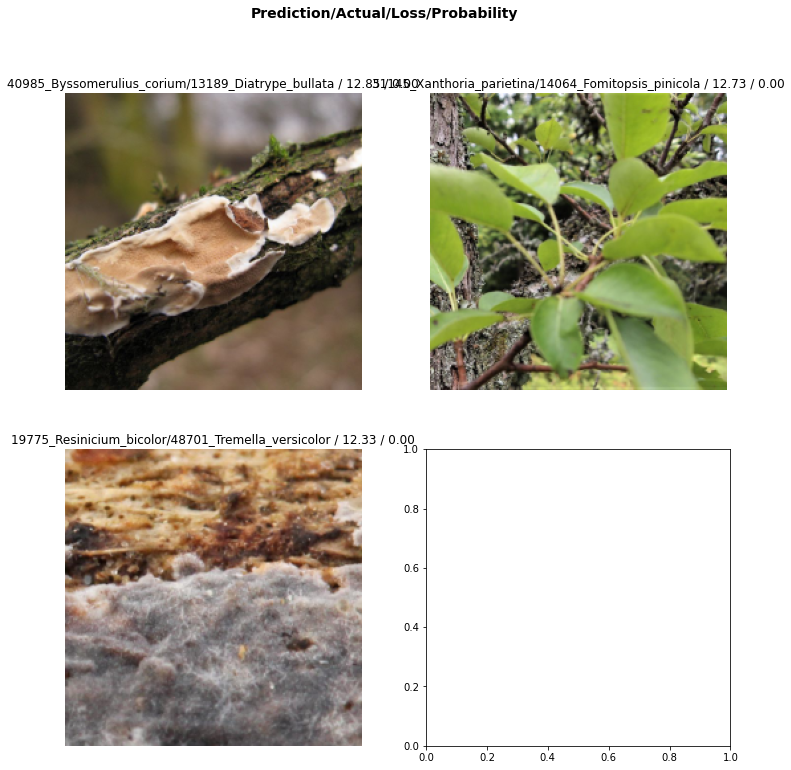

In [106]:
results.plot_top_losses(3)

In [107]:
results.preds[:2]

tensor([[7.2282e-05, 2.1256e-04, 1.0683e-03,  ..., 2.6851e-04, 3.0027e-04,
         8.4574e-04],
        [8.6251e-05, 2.9662e-04, 1.0395e-05,  ..., 2.5821e-02, 3.2345e-05,
         4.2731e-05]])

In [108]:
len(results.preds)

17952

# Prediction

In [43]:
preds, _ = learner.get_preds(ds_type=DatasetType.Test)

In [73]:
pred_classes = [np.array(p).argsort()[-3:][::-1] for p in preds]

In [75]:
pred_classes = [" ".join(p.astype(str) ) for p in pred_classes]

In [29]:
with open("data/test2.json") as json_file:
    data = json.load(json_file)
    files_to_ids = {i["file_name"] : i["id"] for i in data["images"]}

In [79]:
ids = [files_to_ids["test/" + f.name] for f in learner.data.test_ds.items]

In [80]:
pred_classes[:5]

['566 119 955', '269 686 1115', '555 1200 850', '1377 410 357', '303 854 1110']

In [81]:
ids[:5]

[123772, 42782, 8956, 52044, 114626]

In [82]:
df = pd.DataFrame({"id": ids, "predicted": pred_classes})

In [83]:
df[:5]

,id,predicted
0,123772,566 119 955
1,42782,269 686 1115
2,8956,555 1200 850
3,52044,1377 410 357
4,114626,303 854 1110


In [84]:
df.to_csv('data/submission.csv', index=False)

# Scores

1. Initial prediction
    - train_loss: 3.401437
    - valid_loss: 3.261729
    - top_k_accuracy: 0.513369
    - test_score private: 0.69770
    - test_score public: 0.70037